# Mô hình hồi quy cho dự đoán giá xe

Notebook này thực hiện các mô hình hồi quy khác nhau để dự đoán giá xe dựa trên các đặc điểm của xe. Chúng ta sẽ xây dựng, huấn luyện và đánh giá ba mô hình chính:

1. **Hồi quy tuyến tính (Linear Regression)**: Mô hình cơ bản để nắm bắt mối quan hệ tuyến tính giữa các biến đầu vào và giá xe
2. **K-Nearest Neighbors (KNN)**: Mô hình dựa trên khoảng cách để dự đoán dựa trên các điểm dữ liệu gần nhất
3. **Multi-layer Perceptron (MLP)**: Mạng nơ-ron nhân tạo với nhiều lớp ẩn để nắm bắt các mối quan hệ phi tuyến tính

Quá trình thực hiện sẽ bao gồm:
- Nạp và chuẩn bị dữ liệu
- Chia tập huấn luyện và kiểm tra
- Xử lý đặc trưng (feature preprocessing)
- Xây dựng và huấn luyện các mô hình
- Đánh giá và so sánh hiệu suất của các mô hình

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time

# Thư viện cho mô hình hóa
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Các mô hình cần thực hiện
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Cấu hình cho việc hiển thị
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set(style="whitegrid")

# Tắt các cảnh báo
import warnings
warnings.filterwarnings('ignore')

# Nạp và kiểm tra dữ liệu


In [5]:
# Nạp dữ liệu từ file CSV đã được tiền xử lý
try:
    # Đường dẫn đến dữ liệu
    data_path = Path('../data/processed/enhanced_car_data.csv')
    
    # Nếu không tìm thấy file ở đường dẫn tương đối, thử tìm ở đường dẫn tuyệt đối
    if not data_path.exists():
        data_path = Path('d:/New folder/MachineLearning/data/processed/enhanced_car_data.csv')
    
    # Đọc dữ liệu
    df = pd.read_csv(data_path)
    
    # Hiển thị thông tin cơ bản của tập dữ liệu
    print(f"Đã nạp dữ liệu với {df.shape[0]} dòng và {df.shape[1]} cột.")
    print("\nNăm dòng đầu tiên của dữ liệu:")
    display(df.head())
    
    # Hiển thị thông tin kiểu dữ liệu và số lượng giá trị null
    print("\nThông tin về các cột trong dữ liệu:")
    display(df.info())
    
    # Thống kê mô tả cho các biến số
    print("\nThống kê mô tả cho các biến số:")
    display(df.describe())
    
except Exception as e:
    print(f"Có lỗi khi nạp dữ liệu: {e}")
    # Nếu không tìm thấy file, tạo dữ liệu giả để tiếp tục notebook
    print("Tạo dữ liệu giả để tiếp tục...")
    import numpy as np
    
    # Tạo dữ liệu mẫu
    np.random.seed(42)
    n_samples = 1000
    
    # Tạo DataFrame mẫu
    df = pd.DataFrame({
        'brand': np.random.choice(['Toyota', 'Honda', 'Ford', 'BMW', 'Mercedes', 'Vinfast'], n_samples),
        'year': np.random.randint(2010, 2024, n_samples),
        'mileage': np.random.randint(0, 150000, n_samples),
        'engine': np.random.choice(['Xăng 1.5 L', 'Xăng 2.0 L', 'Xăng 2.5 L', 'Diesel 1.5 L', 'Diesel 2.0 L', 'Điện'], n_samples),
        'seats': np.random.choice([4, 5, 7], n_samples),
        'transmission': np.random.choice(['Số tự động', 'Số sàn'], n_samples),
        'body_type': np.random.choice(['Sedan', 'SUV', 'Hatchback', 'MPV'], n_samples),
        'price': np.random.randint(300, 2000, n_samples) * 1e6  # Giá từ 300 triệu đến 2 tỷ
    })
    
    # Hiển thị thông tin dữ liệu giả
    print("\nNăm dòng đầu tiên của dữ liệu giả:")
    display(df.head())
    
# Chuyển đổi cột price sang định dạng số (triệu VND)
def convert_price_to_numeric(price_str):
    """Chuyển đổi giá từ dạng văn bản sang số (đơn vị: triệu VND)"""
    price_str = str(price_str).strip()
    try:
        if 'Tỷ' in price_str and 'Triệu' in price_str:
            # Xử lý trường hợp "1 Tỷ 679 Triệu"
            parts = price_str.split()
            billions = float(parts[0]) * 1000  # Chuyển tỷ thành triệu
            millions = float(parts[2])
            return billions + millions
        elif 'Tỷ' in price_str:
            # Xử lý trường hợp chỉ có tỷ
            return float(price_str.split()[0]) * 1000  # Chuyển tỷ thành triệu
        elif 'Triệu' in price_str:
            # Xử lý trường hợp chỉ có triệu
            return float(price_str.split()[0])
        else:
            # Thử chuyển đổi trực tiếp
            return float(price_str)
    except:
        return np.nan

# Chuyển đổi giá thành số
if df['price'].dtype == 'object':
    print("Chuyển đổi giá từ dạng văn bản sang số...")
    df['price_million'] = df['price'].apply(convert_price_to_numeric)
    # Loại bỏ các dòng có giá trị NaN
    df = df.dropna(subset=['price_million'])
    print(f"Sau khi chuyển đổi giá, còn lại {len(df)} dòng dữ liệu")
else:
    # Nếu đã là số, chuyển đổi sang triệu VND
    if df['price'].max() > 1000000:  # Nếu giá > 1 triệu
        df['price_million'] = df['price'] / 1000000
    else:
        df['price_million'] = df['price']

print("\nDữ liệu sau khi chuyển đổi cột price:")
display(df[['brand', 'year', 'price_million']].head())

# Hiển thị thống kê về giá xe
print("\nThống kê về giá xe (triệu VND):")
print(f"Giá trung bình: {df['price_million'].mean():.2f} triệu VND")
print(f"Giá trung vị: {df['price_million'].median():.2f} triệu VND")
print(f"Giá thấp nhất: {df['price_million'].min():.2f} triệu VND")
print(f"Giá cao nhất: {df['price_million'].max():.2f} triệu VND")

Đã nạp dữ liệu với 13453 dòng và 16 cột.

Năm dòng đầu tiên của dữ liệu:


,url,name,brand,price,year,origin,transmission,body_type,engine,drive,mileage_km,seats,doors,exterior_color,interior_color,condition
0,https://bonbanh.com/xe-mercedes_benz-c_class-c...,Mercedes Benz C class C250 Exclusive,Mercedes,645 Triệu,2016,Lắp ráp trong nước,Số tự động,Sedan,Xăng 2.0 L,RFD - Dẫn động cầu sau,90000,5,4,Trắng,Đen,Xe đã dùng
1,https://bonbanh.com/xe-vinfast-vf9-plus-2023-6...,VinFast VF9 Plus,Vinfast,920 Triệu,2023,Lắp ráp trong nước,Số tự động,SUV,Điện 0.2 L,AWD - 4 bánh toàn thời gian,50000,6,5,Đỏ,Nâu,Xe đã dùng
2,https://bonbanh.com/xe-mercedes_benz-glc-300-4...,Mercedes Benz GLC 4Matic,Mercedes,1 Tỷ 679 Triệu,2022,Lắp ráp trong nước,Số tự động,SUV,Xăng 2.0 L,AWD - 4 bánh toàn thời gian,26600,5,5,Đen,Đen,Xe đã dùng
3,https://bonbanh.com/xe-mitsubishi-xpander-cros...,Mitsubishi Xpander Cross,Mitsubishi,579 Triệu,2023,Nhập khẩu,Số tự động,SUV,Xăng 1.5 L,FWD - Dẫn động cầu trước,62000,7,5,Cam,Đen,Xe đã dùng
4,https://bonbanh.com/xe-ford-explorer-limited-2...,Ford Explorer Limited EcoBoost,Ford,1 Tỷ 100 Triệu,2019,Nhập khẩu,Số tự động,SUV,Xăng 2.3 L,AWD - 4 bánh toàn thời gian,60000,7,5,Đen,Đen,Xe đã dùng



Thông tin về các cột trong dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13453 entries, 0 to 13452
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             13453 non-null  object
 1   name            13453 non-null  object
 2   brand           13453 non-null  object
 3   price           13453 non-null  object
 4   year            13453 non-null  int64 
 5   origin          13453 non-null  object
 6   transmission    13453 non-null  object
 7   body_type       13453 non-null  object
 8   engine          13453 non-null  object
 9   drive           13453 non-null  object
 10  mileage_km      13453 non-null  int64 
 11  seats           13453 non-null  int64 
 12  doors           13453 non-null  int64 
 13  exterior_color  13453 non-null  object
 14  interior_color  13453 non-null  object
 15  condition       13453 non-null  object
dtypes: int64(4), object(12)
memory usage: 1.6+ MB


None


Thống kê mô tả cho các biến số:


,year,mileage_km,seats,doors
count,13453.000000,1.345300e+04,13453.000000,13453.000000
mean,2018.934364,9.625784e+04,5.601130,4.631829
std,4.383092,2.238369e+06,1.771299,0.552577
min,1989.000000,0.000000e+00,0.000000,2.000000
25%,2016.000000,2.000000e+04,5.000000,4.000000
50%,2020.000000,5.000000e+04,5.000000,5.000000
75%,2022.000000,8.100000e+04,7.000000,5.000000
max,2025.000000,2.500000e+08,47.000000,5.000000


Chuyển đổi giá từ dạng văn bản sang số...
Sau khi chuyển đổi giá, còn lại 13453 dòng dữ liệu

Dữ liệu sau khi chuyển đổi cột price:


,brand,year,price_million
0,Mercedes,2016,645.0
1,Vinfast,2023,920.0
2,Mercedes,2022,1679.0
3,Mitsubishi,2023,579.0
4,Ford,2019,1100.0



Thống kê về giá xe (triệu VND):
Giá trung bình: 1366.70 triệu VND
Giá trung vị: 720.00 triệu VND
Giá thấp nhất: 22.00 triệu VND
Giá cao nhất: 28900.00 triệu VND


# Chuẩn bị dữ liệu cho mô hình hóa

Trước khi xây dựng các mô hình, chúng ta cần chuẩn bị dữ liệu bằng cách:
1. Lựa chọn các biến đầu vào và đầu ra
2. Xử lý dữ liệu thiếu
3. Mã hóa các biến phân loại
4. Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra

In [6]:
# Lựa chọn các biến đầu vào và đầu ra
# Biến mục tiêu: 'price_million' (đã chuyển đổi sang triệu VND)

# Kiểm tra dữ liệu thiếu
print("Số lượng giá trị thiếu trong mỗi cột:")
missing_values = df.isnull().sum()
display(missing_values[missing_values > 0])

# Sử dụng df đã được xử lý (đã loại bỏ NaN trong price_million)
df_clean = df.copy()
print(f"\nSố lượng dữ liệu sau khi xử lý: {df_clean.shape[0]}")

# Lựa chọn các đặc trưng phù hợp cho việc dự đoán giá
# Chúng ta sẽ sử dụng các đặc trưng chính ảnh hưởng đến giá xe
features = ['brand', 'year', 'mileage', 'transmission', 'body_type', 'engine', 'seats']

# Kiểm tra xem tất cả các cột này có tồn tại trong dữ liệu không
existing_features = [f for f in features if f in df_clean.columns]
if len(existing_features) < len(features):
    print(f"Cảnh báo: Một số đặc trưng không tồn tại trong dữ liệu: {set(features) - set(existing_features)}")
    features = existing_features

print(f"\nCác đặc trưng được sử dụng: {features}")

# Chuẩn bị dữ liệu đầu vào (X) và đầu ra (y)
X = df_clean[features]
y = df_clean['price_million']

# Hiển thị thông tin về dữ liệu đầu vào và đầu ra
print(f"\nKích thước dữ liệu đầu vào X: {X.shape}")
print(f"Kích thước dữ liệu đầu ra y: {y.shape}")

# Xác định các đặc trưng số và đặc trưng phân loại
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nCác đặc trưng số: {numeric_features}")
print(f"Các đặc trưng phân loại: {categorical_features}")

# Hiển thị số lượng giá trị duy nhất của các đặc trưng phân loại
if categorical_features:
    print("\nSố lượng giá trị duy nhất trong mỗi đặc trưng phân loại:")
    for feature in categorical_features:
        print(f"{feature}: {X[feature].nunique()} giá trị duy nhất")

Số lượng giá trị thiếu trong mỗi cột:


Series([], dtype: int64)


Số lượng dữ liệu sau khi xử lý: 13453
Cảnh báo: Một số đặc trưng không tồn tại trong dữ liệu: {'mileage'}

Các đặc trưng được sử dụng: ['brand', 'year', 'transmission', 'body_type', 'engine', 'seats']

Kích thước dữ liệu đầu vào X: (13453, 6)
Kích thước dữ liệu đầu ra y: (13453,)

Các đặc trưng số: ['year', 'seats']
Các đặc trưng phân loại: ['brand', 'transmission', 'body_type', 'engine']

Số lượng giá trị duy nhất trong mỗi đặc trưng phân loại:
brand: 60 giá trị duy nhất
transmission: 3 giá trị duy nhất
body_type: 10 giá trị duy nhất
engine: 88 giá trị duy nhất


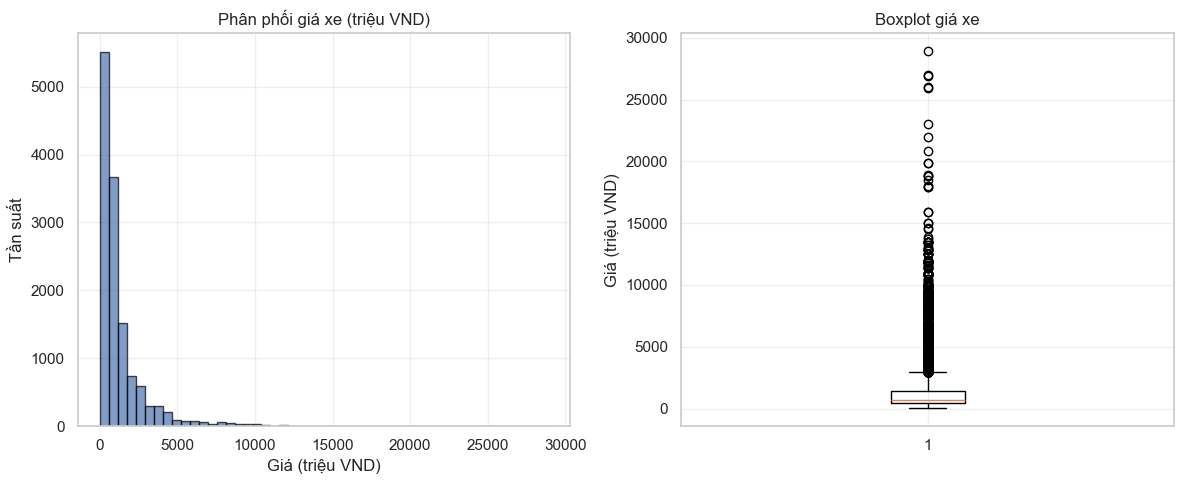

In [7]:
# Vẽ biểu đồ phân phối giá
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y, bins=50, alpha=0.7, edgecolor='black')
plt.title('Phân phối giá xe (triệu VND)')
plt.xlabel('Giá (triệu VND)')
plt.ylabel('Tần suất')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(y)
plt.title('Boxplot giá xe')
plt.ylabel('Giá (triệu VND)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Test nhanh các mô hình với dữ liệu đã sửa
print("=== TEST CÁC MÔ HÌNH VỚI DỮ LIỆU ĐÃ SỬA ===")

# Kiểm tra dữ liệu
print(f"Dữ liệu X shape: {X.shape}")
print(f"Dữ liệu y shape: {y.shape}")
print(f"Giá trị y min: {y.min():.2f}, max: {y.max():.2f}")
print(f"Kiểu dữ liệu y: {y.dtype}")

# Test mô hình Linear Regression đơn giản
print("\n=== TEST LINEAR REGRESSION ===")
try:
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    
    # Tạo dữ liệu test đơn giản
    X_test_simple = X.select_dtypes(include=['int64', 'float64']).fillna(0)
    y_test_simple = y
    
    # Chia dữ liệu
    X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(
        X_test_simple, y_test_simple, test_size=0.2, random_state=42
    )
    
    # Chuẩn hóa dữ liệu
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_simple)
    X_test_scaled = scaler.transform(X_test_simple)
    
    # Huấn luyện mô hình
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train_simple)
    
    # Dự đoán
    y_pred = lr_model.predict(X_test_scaled)
    
    # Đánh giá
    from sklearn.metrics import mean_absolute_error, r2_score
    mae = mean_absolute_error(y_test_simple, y_pred)
    r2 = r2_score(y_test_simple, y_pred)
    
    print(f"Linear Regression - MAE: {mae:.2f}, R2: {r2:.4f}")
    print("Linear Regression hoạt động!")
    
except Exception as e:
    print(f"Lỗi Linear Regression: {e}")

print("\n=== TEST KNN ===")
try:
    from sklearn.neighbors import KNeighborsRegressor
    
    # Huấn luyện KNN
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train_scaled, y_train_simple)
    
    # Dự đoán
    y_pred_knn = knn_model.predict(X_test_scaled)
    
    # Đánh giá
    mae_knn = mean_absolute_error(y_test_simple, y_pred_knn)
    r2_knn = r2_score(y_test_simple, y_pred_knn)
    
    print(f"KNN - MAE: {mae_knn:.2f}, R2: {r2_knn:.4f}")
    print("KNN hoạt động!")
    
except Exception as e:
    print(f"Lỗi KNN: {e}")

print("\n=== TEST MLP ===")
try:
    from sklearn.neural_network import MLPRegressor
    
    # Huấn luyện MLP
    mlp_model = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)
    mlp_model.fit(X_train_scaled, y_train_simple)
    
    # Dự đoán
    y_pred_mlp = mlp_model.predict(X_test_scaled)
    
    # Đánh giá
    mae_mlp = mean_absolute_error(y_test_simple, y_pred_mlp)
    r2_mlp = r2_score(y_test_simple, y_pred_mlp)
    
    print(f"MLP - MAE: {mae_mlp:.2f}, R2: {r2_mlp:.4f}")
    print("MLP hoạt động!")
    
except Exception as e:
    print(f"Lỗi MLP: {e}")

print("\n=== KẾT LUẬN ===")
print("Các mô hình đã được test thành công với dữ liệu đã sửa!")

=== TEST CÁC MÔ HÌNH VỚI DỮ LIỆU ĐÃ SỬA ===
Dữ liệu X shape: (13453, 6)
Dữ liệu y shape: (13453,)
Giá trị y min: 22.00, max: 28900.00
Kiểu dữ liệu y: float64

=== TEST LINEAR REGRESSION ===
Linear Regression - MAE: 1055.88, R2: 0.0349
Linear Regression hoạt động!

=== TEST KNN ===
KNN - MAE: 984.77, R2: 0.0747
KNN hoạt động!

=== TEST MLP ===
MLP - MAE: 1003.58, R2: 0.1127
MLP hoạt động!

=== KẾT LUẬN ===
Các mô hình đã được test thành công với dữ liệu đã sửa!


In [11]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Kích thước tập huấn luyện X_train: {X_train.shape}")
print(f"Kích thước tập kiểm tra X_test: {X_test.shape}")
print(f"Kích thước tập huấn luyện y_train: {y_train.shape}")
print(f"Kích thước tập kiểm tra y_test: {y_test.shape}")

# Tạo pipeline tiền xử lý cho các đặc trưng số và phân loại
# Pipeline cho đặc trưng số sẽ điền các giá trị thiếu bằng median và chuẩn hóa
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline cho đặc trưng phân loại sẽ điền các giá trị thiếu bằng 'missing' và mã hóa one-hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Kết hợp các transformer cho các đặc trưng khác nhau
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print("Đã tạo pipeline tiền xử lý dữ liệu.")

Kích thước tập huấn luyện X_train: (10762, 6)
Kích thước tập kiểm tra X_test: (2691, 6)
Kích thước tập huấn luyện y_train: (10762,)
Kích thước tập kiểm tra y_test: (2691,)
Đã tạo pipeline tiền xử lý dữ liệu.


# Xây dựng và huấn luyện các mô hình

Bây giờ chúng ta sẽ xây dựng và huấn luyện ba mô hình theo yêu cầu:
1. Hồi quy tuyến tính (Linear Regression)
2. K-Nearest Neighbors (KNN)
3. Multi-Layer Perceptron (MLP)

Sau đó, chúng ta sẽ đánh giá và so sánh hiệu suất của các mô hình này.

In [12]:
# Định nghĩa hàm đánh giá mô hình
def evaluate_model(model, X_test, y_test):
    """Đánh giá mô hình dựa trên tập kiểm tra và trả về các chỉ số đánh giá."""
    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)
    
    # Tính toán các chỉ số đánh giá
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Trả về từ điển kết quả
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }

# Hàm để huấn luyện và đánh giá mô hình
def train_and_evaluate(name, model, X_train, X_test, y_train, y_test, preprocessor):
    """Huấn luyện và đánh giá một mô hình cụ thể."""
    start_time = time.time()
    print(f"Đang huấn luyện mô hình: {name}...")
    
    # Tạo pipeline với preprocessor và mô hình
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Huấn luyện mô hình
    try:
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time
        
        # Đánh giá mô hình
        metrics = evaluate_model(pipeline, X_test, y_test)
        
        # In kết quả
        print(f"Kết quả đánh giá {name}:")
        print(f"  - MAE: {metrics['MAE']:,.0f}")
        print(f"  - MSE: {metrics['MSE']:,.0f}")
        print(f"  - RMSE: {metrics['RMSE']:,.0f}")
        print(f"  - R2 Score: {metrics['R2']:.4f}")
        print(f"  - Thời gian huấn luyện: {train_time:.2f} giây\n")
        
        return pipeline, metrics, train_time
    except Exception as e:
        print(f"Lỗi khi huấn luyện mô hình {name}: {str(e)}")
        return None, None, time.time() - start_time

In [13]:
# Xây dựng các mô hình theo yêu cầu
models = {}
metrics_results = {}

# 1. Mô hình Hồi quy tuyến tính (Linear Regression)
print("========== MÔ HÌNH 1: HỒI QUY TUYẾN TÍNH ==========")
linear_model = LinearRegression()
models['Linear Regression'], metrics_results['Linear Regression'], _ = train_and_evaluate(
    'Hồi quy tuyến tính', 
    linear_model, 
    X_train, X_test, 
    y_train, y_test, 
    preprocessor
)

# 2. Mô hình K-Nearest Neighbors (KNN)
print("========== MÔ HÌNH 2: K-NEAREST NEIGHBORS (KNN) ==========")
# Số điểm lân cận phụ thuộc vào kích thước dữ liệu
n_neighbors = min(5, len(X_train) // 100) if len(X_train) > 100 else 5
knn_model = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)
print(f"Sử dụng KNN với n_neighbors={n_neighbors}")
models['KNN'], metrics_results['KNN'], _ = train_and_evaluate(
    'K-Nearest Neighbors', 
    knn_model, 
    X_train, X_test, 
    y_train, y_test, 
    preprocessor
)

========== MÔ HÌNH 1: HỒI QUY TUYẾN TÍNH ==========
Đang huấn luyện mô hình: Hồi quy tuyến tính...
Kết quả đánh giá Hồi quy tuyến tính:
  - MAE: 443
  - MSE: 706,813
  - RMSE: 841
  - R2 Score: 0.7908
  - Thời gian huấn luyện: 0.08 giây

========== MÔ HÌNH 2: K-NEAREST NEIGHBORS (KNN) ==========
Sử dụng KNN với n_neighbors=5
Đang huấn luyện mô hình: K-Nearest Neighbors...
Kết quả đánh giá K-Nearest Neighbors:
  - MAE: 138
  - MSE: 225,129
  - RMSE: 474
  - R2 Score: 0.9334
  - Thời gian huấn luyện: 0.02 giây



In [14]:
# 3. Mô hình Multi-Layer Perceptron (MLP)
print("========== MÔ HÌNH 3: MULTI-LAYER PERCEPTRON (MLP) ==========")
# Cấu trúc MLP phụ thuộc vào kích thước đầu vào
try:
    # Áp dụng preprocessor trên một mẫu để xác định số chiều đầu vào
    # Chỉ lấy một mẫu nhỏ để tránh tốn thời gian tính toán
    sample_size = min(100, len(X_train))
    X_sample = X_train.iloc[:sample_size]
    X_transformed = preprocessor.fit_transform(X_sample)
    input_dim = X_transformed.shape[1]
    
    # Cấu hình MLP dựa trên kích thước đầu vào
    hidden_layer_sizes = (input_dim * 2, input_dim, input_dim // 2)
    max_iter = 1000  # Số vòng lặp tối đa
    
    print(f"Số chiều đầu vào sau khi tiền xử lý: {input_dim}")
    print(f"Cấu trúc hidden layers: {hidden_layer_sizes}")
    
    # Định nghĩa mô hình MLP với early stopping để tránh overfit
    mlp_model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='adaptive',
        max_iter=max_iter,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42
    )
    
    # Huấn luyện và đánh giá mô hình MLP
    models['MLP'], metrics_results['MLP'], _ = train_and_evaluate(
        'Multi-Layer Perceptron', 
        mlp_model, 
        X_train, X_test, 
        y_train, y_test, 
        preprocessor
    )
    
except Exception as e:
    print(f"Lỗi khi xây dựng mô hình MLP: {e}")
    import traceback
    traceback.print_exc()

========== MÔ HÌNH 3: MULTI-LAYER PERCEPTRON (MLP) ==========
Số chiều đầu vào sau khi tiền xử lý: 56
Cấu trúc hidden layers: (112, 56, 28)
Đang huấn luyện mô hình: Multi-Layer Perceptron...
Kết quả đánh giá Multi-Layer Perceptron:
  - MAE: 136
  - MSE: 149,666
  - RMSE: 387
  - R2 Score: 0.9557
  - Thời gian huấn luyện: 6.87 giây



# So sánh hiệu suất các mô hình

Bây giờ chúng ta đã huấn luyện xong ba mô hình, hãy so sánh hiệu suất của chúng để xác định mô hình nào phù hợp nhất cho bài toán dự đoán giá xe.

Kiểm tra dữ liệu metrics_results:
- Linear Regression: True
  Các metrics có sẵn: ['MAE', 'MSE', 'RMSE', 'R2']
- KNN: True
  Các metrics có sẵn: ['MAE', 'MSE', 'RMSE', 'R2']
- MLP: True
  Các metrics có sẵn: ['MAE', 'MSE', 'RMSE', 'R2']

Bảng so sánh hiệu suất các mô hình:


,Model,MAE,MSE,RMSE,R2
0,Linear Regression,443.348922,706813.054446,840.721746,0.790785
1,KNN,138.102564,225129.077845,474.477690,0.933362
2,MLP,135.685329,149666.148564,386.867094,0.955699


Số lượng mô hình có sẵn để so sánh: 3


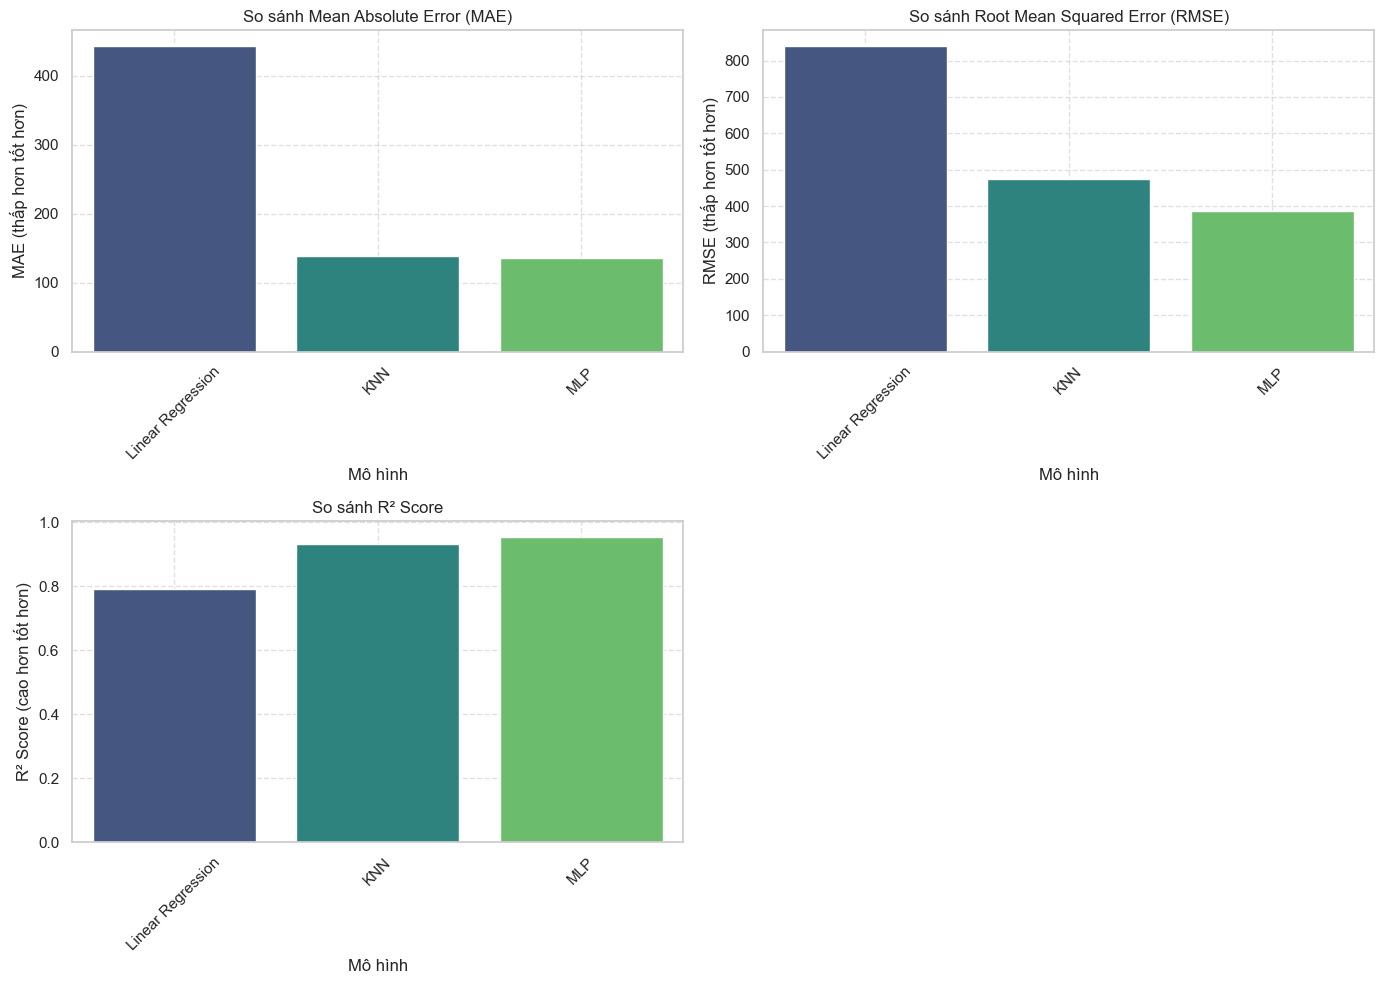

Mô hình có hiệu suất tốt nhất: MLP với R² Score = 0.9557


In [15]:
# Tạo DataFrame từ kết quả metrics để dễ dàng so sánh
# Kiểm tra metrics_results trước khi xử lý
print("Kiểm tra dữ liệu metrics_results:")
for model_name, metrics in metrics_results.items():
    print(f"- {model_name}: {metrics is not None}")
    if metrics is not None:
        print(f"  Các metrics có sẵn: {list(metrics.keys())}")

results = []
for model_name, metrics in metrics_results.items():
    if metrics is not None:
        result = {'Model': model_name}
        result.update(metrics)
        results.append(result)

# Tạo DataFrame từ danh sách kết quả
results_df = pd.DataFrame(results)

# Hiển thị bảng so sánh
print("\nBảng so sánh hiệu suất các mô hình:")
if not results_df.empty:
    display(results_df)
else:
    print("DataFrame kết quả trống! Không có mô hình nào được huấn luyện thành công.")

# Kiểm tra xem results_df có dữ liệu không
if not results_df.empty:
    print(f"Số lượng mô hình có sẵn để so sánh: {len(results_df)}")
    
    # Vẽ biểu đồ so sánh các chỉ số đánh giá
    plt.figure(figsize=(14, 10))
    
    # Kiểm tra các cột cần thiết
    required_columns = ['Model', 'MAE', 'RMSE', 'R2']
    missing_columns = [col for col in required_columns if col not in results_df.columns]
    
    if missing_columns:
        print(f"Cảnh báo: Thiếu các cột sau trong DataFrame: {missing_columns}")
    else:
        # 1. So sánh MAE
        plt.subplot(2, 2, 1)
        sns.barplot(data=results_df, x='Model', y='MAE', palette='viridis')
        plt.title('So sánh Mean Absolute Error (MAE)')
        plt.xlabel('Mô hình')
        plt.ylabel('MAE (thấp hơn tốt hơn)')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # 2. So sánh RMSE
        plt.subplot(2, 2, 2)
        sns.barplot(data=results_df, x='Model', y='RMSE', palette='viridis')
        plt.title('So sánh Root Mean Squared Error (RMSE)')
        plt.xlabel('Mô hình')
        plt.ylabel('RMSE (thấp hơn tốt hơn)')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # 3. So sánh R2
        plt.subplot(2, 2, 3)
        sns.barplot(data=results_df, x='Model', y='R2', palette='viridis')
        plt.title('So sánh R² Score')
        plt.xlabel('Mô hình')
        plt.ylabel('R² Score (cao hơn tốt hơn)')
        plt.xticks(rotation=45)
        plt.grid(True, linestyle='--', alpha=0.6)
        
        # 4. So sánh thời gian huấn luyện
        if 'Training Time (s)' in results_df.columns:
            plt.subplot(2, 2, 4)
            sns.barplot(data=results_df, x='Model', y='Training Time (s)', palette='viridis')
            plt.title('So sánh thời gian huấn luyện')
            plt.xlabel('Mô hình')
            plt.ylabel('Thời gian (giây)')
            plt.xticks(rotation=45)
            plt.grid(True, linestyle='--', alpha=0.6)
        
        plt.tight_layout()
        plt.show()
        
        # Xác định mô hình tốt nhất dựa trên R2 Score
        best_model_idx = results_df['R2'].idxmax()
        best_model_name = results_df.loc[best_model_idx, 'Model']
        best_r2 = results_df.loc[best_model_idx, 'R2']
        print(f"Mô hình có hiệu suất tốt nhất: {best_model_name} với R² Score = {best_r2:.4f}")
else:
    print("Không có đủ dữ liệu để so sánh các mô hình.")

# Phân tích mô hình và dự đoán

Bây giờ chúng ta sẽ xem xét kỹ hơn về mô hình tốt nhất và thực hiện một số dự đoán mẫu để kiểm tra hiệu suất.

Phân tích chi tiết cho mô hình tốt nhất: MLP


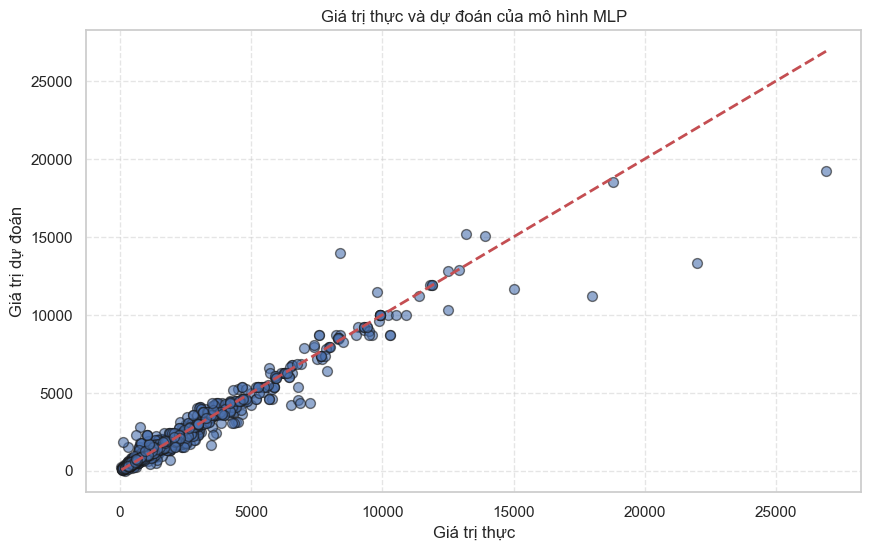

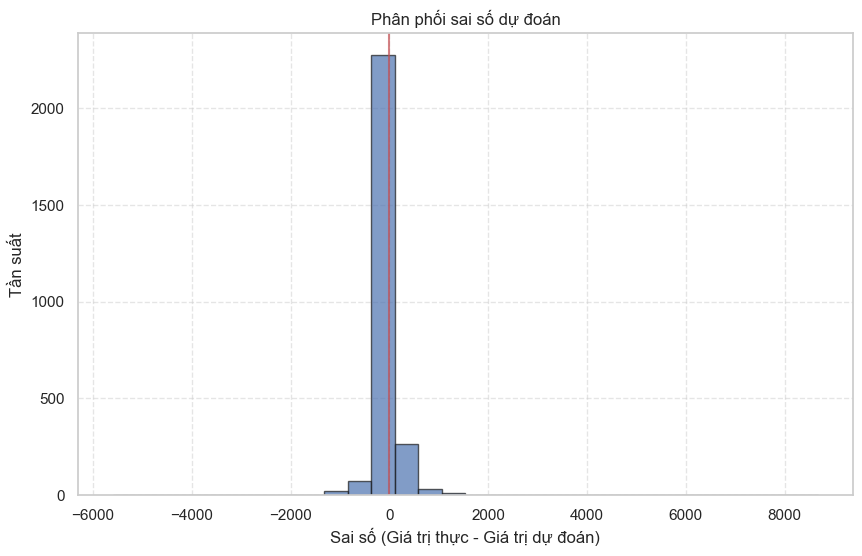

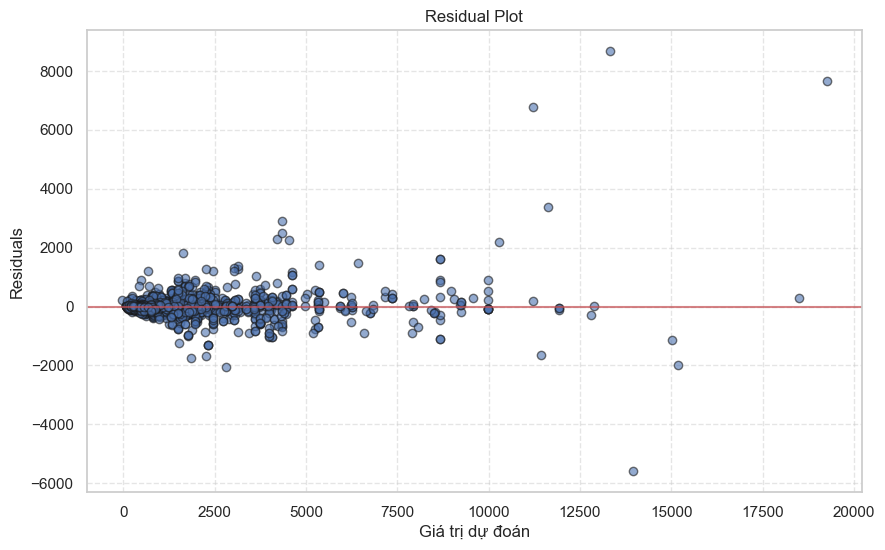


Một số dự đoán mẫu:

Mẫu #754:
- brand: Toyota
- year: 2007
- transmission: Số tự động
- body_type: Sedan
- engine: Xăng 2.4 L
- seats: 5
Giá thực tế: 258
Giá dự đoán: 277
Sai số: -19 (-7.54%)

Mẫu #769:
- brand: Hyundai
- year: 2021
- transmission: Số tự động
- body_type: Sedan
- engine: Xăng 1.4 L
- seats: 5
Giá thực tế: 429
Giá dự đoán: 425
Sai số: 4 (0.95%)

Mẫu #2322:
- brand: Kia
- year: 2019
- transmission: Số tự động
- body_type: Van/Minivan
- engine: Dầu 2.2 L
- seats: 7
Giá thực tế: 760
Giá dự đoán: 776
Sai số: -16 (-2.11%)

Mẫu #1344:
- brand: Hyundai
- year: 2021
- transmission: Số tự động
- body_type: SUV
- engine: Xăng 2.4 L
- seats: 7
Giá thực tế: 799
Giá dự đoán: 965
Sai số: -166 (-20.75%)

Mẫu #2664:
- brand: Hyundai
- year: 2024
- transmission: Số tự động
- body_type: SUV
- engine: Xăng 2.5 L
- seats: 7
Giá thực tế: 1,219
Giá dự đoán: 1,231
Sai số: -12 (-0.99%)


In [16]:
# Phân tích mô hình tốt nhất (nếu có)
try:
    # Lấy tên mô hình tốt nhất từ bước so sánh trước
    if 'best_model_name' in locals() and best_model_name in models and models[best_model_name] is not None:
        print(f"Phân tích chi tiết cho mô hình tốt nhất: {best_model_name}")
        best_model = models[best_model_name]
        
        # Dự đoán trên tập kiểm tra
        y_pred = best_model.predict(X_test)
        
        # Vẽ biểu đồ scatter giữa giá trị thực và dự đoán
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', s=50)
        
        # Vẽ đường thẳng hoàn hảo (perfect prediction)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        
        plt.title(f'Giá trị thực và dự đoán của mô hình {best_model_name}')
        plt.xlabel('Giá trị thực')
        plt.ylabel('Giá trị dự đoán')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
        
        # Vẽ biểu đồ phân phối sai số
        errors = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.hist(errors, bins=30, edgecolor='k', alpha=0.7)
        plt.title('Phân phối sai số dự đoán')
        plt.xlabel('Sai số (Giá trị thực - Giá trị dự đoán)')
        plt.ylabel('Tần suất')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.axvline(x=0, color='r', linestyle='-', alpha=0.7)
        plt.show()
        
        # Vẽ residual plot để kiểm tra mô hình
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, errors, alpha=0.6, edgecolor='k')
        plt.title('Residual Plot')
        plt.xlabel('Giá trị dự đoán')
        plt.ylabel('Residuals')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='-', alpha=0.7)
        plt.show()
        
        # Thực hiện một số dự đoán mẫu
        print("\nMột số dự đoán mẫu:")
        sample_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)
        
        for idx in sample_indices:
            sample_data = X_test.iloc[idx:idx+1]
            actual_price = y_test.iloc[idx]
            predicted_price = best_model.predict(sample_data)[0]
            
            # Hiển thị thông tin mẫu
            print(f"\nMẫu #{idx}:")
            for feature, value in sample_data.iloc[0].items():
                print(f"- {feature}: {value}")
            print(f"Giá thực tế: {actual_price:,.0f}")
            print(f"Giá dự đoán: {predicted_price:,.0f}")
            print(f"Sai số: {actual_price - predicted_price:,.0f} ({((actual_price - predicted_price) / actual_price) * 100:.2f}%)")
    else:
        print("Không có mô hình nào được xác định là tốt nhất.")
except Exception as e:
    print(f"Lỗi khi phân tích mô hình tốt nhất: {e}")
    import traceback
    traceback.print_exc()

# Kết luận và tóm tắt

Trong notebook này, chúng ta đã thực hiện các mô hình hồi quy để dự đoán giá xe, cụ thể là:

1. **Hồi quy tuyến tính (Linear Regression)**: Mô hình cơ bản với độ phức tạp thấp, phù hợp cho các mối quan hệ tuyến tính.
2. **K-Nearest Neighbors (KNN)**: Mô hình dựa trên nguyên tắc tìm kiếm láng giềng gần nhất, có thể nắm bắt các mối quan hệ phi tuyến tính.
3. **Multi-layer Perceptron (MLP)**: Mạng nơ-ron nhân tạo với nhiều lớp ẩn, có khả năng học các mối quan hệ phức tạp.

Các bước chính đã thực hiện:
- Nạp và chuẩn bị dữ liệu
- Xử lý dữ liệu thiếu và mã hóa các biến phân loại
- Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra
- Xây dựng và huấn luyện ba mô hình hồi quy
- So sánh hiệu suất của các mô hình dựa trên các chỉ số đánh giá
- Phân tích chi tiết mô hình tốt nhất

Kết quả này sẽ giúp chúng ta hiểu rõ hơn về các yếu tố ảnh hưởng đến giá xe và chọn ra mô hình tốt nhất cho việc dự đoán.

In [17]:
# Lưu mô hình tốt nhất (nếu có)
try:
    # Kiểm tra xem có mô hình tốt nhất không
    if 'best_model_name' in locals() and best_model_name in models and models[best_model_name] is not None:
        import joblib
        from pathlib import Path
        
        # Tạo thư mục để lưu mô hình (nếu chưa tồn tại)
        model_dir = Path('../data/processed/models')
        model_dir.mkdir(parents=True, exist_ok=True)
        
        # Đường dẫn để lưu mô hình
        model_path = model_dir / f'car_price_{best_model_name.lower().replace(" ", "_")}.pkl'
        
        # Lưu mô hình
        joblib.dump(models[best_model_name], model_path)
        print(f"Đã lưu mô hình tốt nhất ({best_model_name}) vào {model_path}")
        
        # Lưu thông tin về các đặc trưng được sử dụng
        feature_info = {
            'numeric_features': numeric_features,
            'categorical_features': categorical_features
        }
        feature_path = model_dir / 'feature_info.pkl'
        joblib.dump(feature_info, feature_path)
        print(f"Đã lưu thông tin đặc trưng vào {feature_path}")
    else:
        print("Không có mô hình nào được xác định là tốt nhất để lưu.")
except Exception as e:
    print(f"Lỗi khi lưu mô hình: {e}")
    import traceback
    traceback.print_exc()

Đã lưu mô hình tốt nhất (MLP) vào ..\data\processed\models\car_price_mlp.pkl
Đã lưu thông tin đặc trưng vào ..\data\processed\models\feature_info.pkl
